In [2]:
import nltk, re
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from nltk.data import find
from nltk import word_tokenize
from nltk.collocations import *
from string import punctuation
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize, blankline_tokenize
import string
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

/Users/Beth/anaconda/envs/py3k/lib/python3.5/site-packages/gensim-0.13.3-py3.5-macosx-10.6-x86_64.egg/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
f = open("OvensData_sp.txt") # import text
raw = f.read()

In [14]:
def text_cleaning(data):
    new = regexp_tokenize(data, pattern='\w+|\$[\d\.]+|\S+')
    punctuation = [':', ',', '.', '!', '\'', '[', ']',')','(','--','-','..','...'] 
    new = [w for w in new if w not in punctuation] # Remove punctuation
    ' '.join(new[0:10])
    normalized = [w for w in new if w.lower() not in stopwords.words('english') and w not in string.punctuation]
    ' '.join(normalized[0:10]) # Remove stopwords
    new2 = []
    for word in normalized:
        new2.append(word.lower()) # all text is lowercase
    return(new2)  

In [15]:
text_norm = text_cleaning(raw) # normalize raw text

In [79]:
from nltk import FreqDist
freqdist = FreqDist(text_norm)
freqdist.most_common(20)

[('heat', 4947),
 ('car', 2714),
 ('sun', 2375),
 ('light', 1784),
 ('inside', 1665),
 ('radiation', 1613),
 ('atmosphere', 1176),
 ('box', 1169),
 ('would', 1117),
 ("'s", 1104),
 ('air', 1104),
 ('glass', 1081),
 ('outside', 1055),
 ('solar', 1014),
 ('like', 947),
 ('greenhouse', 939),
 ('convection', 889),
 ('earth', 874),
 ('reflect', 864),
 ('wide', 847)]

# Word2Vec & WordNet Comparison #

In [3]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.Word2Vec.load_word2vec_format(word2vec_sample, binary=False)

## Using nouns: heat, sun, light, radiation, atmosphere (from unigrams, above) ##

### "Heat" ###
WordNet was better here, since humidity (especially) doesn't fall in the same group as "heat"

In [20]:
model.most_similar(positive=['heat'], topn = 5) #Word2Vec Output

[('humidity', 0.5952581763267517),
 ('temperature', 0.5625722408294678),
 ('temperatures', 0.5457080602645874),
 ('heating', 0.5286707282066345),
 ('humid', 0.5064624547958374)]

In [32]:
wn.synsets('heat') #WordNet output
print('1:',wn.synset('heat.n.01').definition())
print('2:',wn.synset('hotness.n.01').definition())
print('3:',wn.synset('heat.n.03').definition())

1: a form of energy that is transferred by a difference in temperature
2: the presence of heat
3: the sensation caused by heat energy


### "Sun" ###
Both WordNet and Word2Vec did well here. The Word2Vec most similar words captured a lot of words students use as synonyms for sun.

In [21]:
model.most_similar(positive=['sun'], topn = 5)

[('sunlight', 0.7269680500030518),
 ('sunshine', 0.6767958402633667),
 ('rays', 0.601547360420227),
 ('sunny', 0.5643970370292664),
 ('shade', 0.5370141267776489)]

In [35]:
wn.synsets('sun') #WordNet output
print('1:',wn.synset('sun.n.01').definition())
print('2:',wn.synset('sunlight.n.01').definition())
print('3:',wn.synset('sun.n.03').definition())

1: the star that is the source of light and heat for the planets in the solar system
2: the rays of the sun
3: a person considered as a source of warmth or energy or glory etc


### "Light" ###
Both WordNet and Word2Vec did pretty well here, but the WordNet definition captures the physics part we were going for

In [22]:
model.most_similar(positive=['light'], topn = 5)

[('lights', 0.5505942106246948),
 ('illumination', 0.5342713594436646),
 ('Light', 0.4914782643318176),
 ('glow', 0.4902392625808716),
 ('illuminate', 0.49018049240112305)]

In [37]:
wn.synsets('light') #WordNet output
print('1:',wn.synset('light.n.01').definition())
print('2:',wn.synset('light.n.02').definition())
print('3:',wn.synset('light.n.03').definition())

1: (physics) electromagnetic radiation that can produce a visual sensation
2: any device serving as a source of illumination
3: a particular perspective or aspect of a situation


### "Radiation" ###
Here the WordNet output is most similar to the meaning most student responses use - radiation as a synonym for energy

In [23]:
model.most_similar(positive=['radiation'], topn = 5)

[('radioactivity', 0.7983198165893555),
 ('Radiation', 0.7779667973518372),
 ('radioactive', 0.6833881735801697),
 ('radiations', 0.6524677276611328),
 ('iodine', 0.5621435642242432)]

In [40]:
wn.synsets('radiation') #WordNet output
print('1:',wn.synset('radiation.n.01').definition())
print('2:',wn.synset('radiation.n.02').definition())
print('3:',wn.synset('radiation_sickness.n.01').definition())

1: energy that is radiated or transmitted in the form of rays or waves or particles
2: the act of spreading outward from a central source
3: syndrome resulting from exposure to ionizing radiation (e.g., exposure to radioactive chemicals or to nuclear explosions); low doses cause diarrhea and nausea and vomiting and sometimes loss of hair; greater exposure can cause sterility and cataracts and some forms of cancer and other diseases; severe exposure can cause death within hours


### "Atmosphere" ###
Since students were not writing about ambiance, and instead only writing about the atmosphere from a science perspective, WordNet probably worked better here. 

In [24]:
model.most_similar(positive=['atmosphere'], topn = 5)

[('atmospheres', 0.7033057808876038),
 ('ambiance', 0.623522937297821),
 ('environment', 0.5103297233581543),
 ('atmospheric', 0.48651421070098877),
 ('aura', 0.4704725444316864)]

In [42]:
wn.synsets('atmosphere') #WordNet output
print('1:',wn.synset('atmosphere.n.01').definition())
print('2:',wn.synset('standard_atmosphere.n.01').definition())
print('3:',wn.synset('atmosphere.n.03').definition())

1: a particular environment or surrounding influence
2: a unit of pressure: the pressure that will support a column of mercury 760 mm high at sea level and 0 degrees centigrade
3: the mass of air surrounding the Earth


## Using Verbs: claim, reflect, get, think, absorb ##

Here there was some stronger differences between WordNet and Word2Vec. WordNet often gave nouns as the top related word. However, Word2Vec didn't often give actual synonyms, instead giving other forms of the same verb. Overall, it seems that Word2Vec worked better with verbs.

### "Claim"###

In [49]:
model.most_similar(positive=['claim'], topn = 5)

[('claims', 0.7393444776535034),
 ('claiming', 0.6842917203903198),
 ('claimed', 0.6302383542060852),
 ('assertion', 0.5973958373069763),
 ('Claim', 0.5837839841842651)]

In [51]:
wn.synsets('claim') #WordNet output
print('1:',wn.synset('claim.n.01').definition())
print('2:',wn.synset('claim.n.02').definition())
print('3:',wn.synset('claim.n.03').definition())

1: an assertion of a right (as to money or property)
2: an assertion that something is true or factual
3: demand for something as rightful or due


### "Reflect" ###

In [52]:
model.most_similar(positive=['reflect'], topn = 5)

[('reflected', 0.7501716613769531),
 ('reflects', 0.6908378005027771),
 ('reflecting', 0.6745986342430115),
 ('reflection', 0.5960354804992676),
 ('reflective', 0.5531980991363525)]

In [54]:
wn.synsets('reflect') #WordNet output
print('1:',wn.synset('reflect.v.01').definition())
print('2:',wn.synset('chew_over.v.01').definition())
print('3:',wn.synset('reflect.v.03').definition())

1: manifest or bring back
2: reflect deeply on a subject
3: to throw or bend back (from a surface)


### "Get" ###

In [55]:
model.most_similar(positive=['get'], topn = 5)

[('getting', 0.7506692409515381),
 ('got', 0.7244825959205627),
 ('gets', 0.642885684967041),
 ('gotten', 0.6259446740150452),
 ('Getting', 0.6206594109535217)]

In [58]:
wn.synsets('get') #WordNet output
print('1:',wn.synset('get.n.01').definition())
print('2:',wn.synset('get.v.01').definition())
print('3:',wn.synset('become.v.01').definition())

1: a return on a shot that seemed impossible to reach and would normally have resulted in a point for the opponent
2: come into the possession of something concrete or abstract
3: enter or assume a certain state or condition


### "Think" ###

In [60]:
model.most_similar(positive=['think'], topn = 5)

[('know', 0.7344212532043457),
 ('guess', 0.7197477221488953),
 ('suppose', 0.7155848741531372),
 ('really', 0.7071927785873413),
 ('thought', 0.6869825720787048)]

In [62]:
wn.synsets('think') #WordNet output
print('1:',wn.synset('think.n.01').definition())
print('2:',wn.synset('think.v.01').definition())
print('3:',wn.synset('think.v.02').definition())

1: an instance of deliberate thinking
2: judge or regard; look upon; judge
3: expect, believe, or suppose


### "Absorb" ###

In [63]:
model.most_similar(positive=['absorb'], topn = 5)

[('absorbed', 0.6968178153038025),
 ('absorbs', 0.6618795394897461),
 ('absorbing', 0.6391947269439697),
 ('compensate', 0.49938833713531494),
 ('soak', 0.49513673782348633)]

In [65]:
wn.synsets('absorb') #WordNet output
print('1:',wn.synset('absorb.v.01').definition())
print('2:',wn.synset('absorb.v.02').definition())
print('3:',wn.synset('absorb.v.03').definition())

1: become imbued
2: take up mentally
3: take up, as of debts or payments


## Using Adjectives: skinny, tall, dark, cold, shiny ##
These words seem to only work okay in both Word2Vec and WordNet. In WordNet some words have all of the top synsets  listed as nouns. However, there are some cases, like "skinny" where Word2Vec also lists most common words as something like "blonde". 

### "Skinny" ###

In [72]:
model.most_similar(positive=['skinny'], topn = 5)

[('chubby', 0.6833444237709045),
 ('scrawny', 0.636683464050293),
 ('blond', 0.5859364867210388),
 ('slender', 0.5813267230987549),
 ('svelte', 0.5721723437309265)]

In [71]:
wn.synsets('skinny') #WordNet output
print('1:',wn.synset('skinny.n.01').definition())
print('2:',wn.synset('scraggy.s.01').definition())
print('3:',wn.synset('skinny.a.02').definition())

1: confidential information about a topic or person
2: being very thin
3: of or relating to or resembling skin


### "Tall" ###

In [73]:
model.most_similar(positive=['tall'], topn = 5)

[('taller', 0.6896722316741943),
 ('Tall', 0.6415977478027344),
 ('towering', 0.5926452875137329),
 ('lanky', 0.580865740776062),
 ('wiry', 0.5671008229255676)]

In [74]:
wn.synsets('tall') #WordNet output
print('1:',wn.synset('tall.n.01').definition())
print('2:',wn.synset('tall.a.01').definition())
print('3:',wn.synset('grandiloquent.s.01').definition())

1: a garment size for a tall person
2: great in vertical dimension; high in stature
3: lofty in style


### "Dark" ###

In [75]:
model.most_similar(positive=['dark'], topn = 5)

[('darkened', 0.6051950454711914),
 ('darker', 0.596818745136261),
 ('gray', 0.5935566425323486),
 ('darkness', 0.5614001750946045),
 ('darkest', 0.5517755746841431)]

In [83]:
wn.synsets('dark') #WordNet output
print('1:',wn.synset('dark.n.01').definition())
print('2:',wn.synset('iniquity.n.01').definition())
print('3:',wn.synset('darkness.n.02').definition())

1: absence of light or illumination
2: absence of moral or spiritual values
3: an unilluminated area


### "Cold" ###

In [76]:
model.most_similar(positive=['cold'], topn = 5)

[('chilly', 0.6878556609153748),
 ('frigid', 0.677040696144104),
 ('Cold', 0.6727538108825684),
 ('chill', 0.6324008107185364),
 ('warm', 0.595303475856781)]

In [85]:
wn.synsets('cold') #WordNet output
print('1:',wn.synset('cold.n.01').definition())
print('2:',wn.synset('coldness.n.03').definition())
print('3:',wn.synset('cold.n.03').definition())

1: a mild viral infection involving the nose and respiratory passages (but not the lungs)
2: the absence of heat
3: the sensation produced by low temperatures


### "Shiny" ###

In [80]:
model.most_similar(positive=['shiny'], topn = 5)

[('gleaming', 0.6916888952255249),
 ('snazzy', 0.6205712556838989),
 ('glistening', 0.6141441464424133),
 ('sleek', 0.6051310896873474),
 ('silvery', 0.5718910694122314)]

In [87]:
wn.synsets('shiny') #WordNet output
print('1:',wn.synset('glistening.s.01').definition())
print('2:',wn.synset('glazed.a.03').definition())
print('3:',wn.synset('bright.s.05').definition())

1: reflecting light
2: having a shiny surface or coating
3: made smooth and bright by or as if by rubbing; reflecting a sheen or glow


# K-Means #

In [16]:
c = pd.read_excel("EmbeddedOvens.xls")
c.head()
c['Text'] = c['Text'].astype('U')
c['Score'] = c['Score'].astype(np.int32)
c = c.loc[c['Score'] > 1]
text = c['Text'].tolist()
c.head()
# This data comes from students responses to one question about how solar radiation is tranformed into heat

,Text,Score,QuestionType,new_Score,new_Score2
0,if we angel the tin foil toward the plastic wr...,4,1,4,3
1,Because... black absorbs heat and that ill giv...,7,1,4,3
2,Because...it lets more ssolar radiation.\n\nTh...,3,1,3,2
3,The changes we would make are take out the ple...,2,1,2,2
4,Because... They used the plexiglass\n\nWe said...,2,1,2,2


In [17]:
# Check the length of the list
len(text)

978

In [18]:
# The following method and code is adapted from Brandon Rose's "Document Clustering with Python"

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [19]:
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in text:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [20]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 27860 items in vocab_frame


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(text) #fit the vectorizer to text

print(tfidf_matrix.shape)

CPU times: user 893 ms, sys: 4.88 ms, total: 898 ms
Wall time: 899 ms
(978, 21)


In [22]:
terms = tfidf_vectorizer.get_feature_names()

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [27]:
from sklearn.cluster import KMeans

num_clusters = 7 # Same number of clusters as number of scored categories is 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 612 ms, sys: 3.43 ms, total: 616 ms
Wall time: 618 ms


In [28]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [29]:
both = { 'sent': text, 'cluster': clusters}

frame = pd.DataFrame(both, index = [clusters] , columns = ['cluster'])

In [30]:
frame['cluster'].value_counts() #number of responses per cluster (clusters from 0 to 4)

# Interesting that these scores are so evenly distributed

2    176
1    166
6    159
3    153
4    139
5    123
0     62
Name: cluster, dtype: int64

In [31]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace

# These words seem mostly the same, not surprising because the students use the same types of words no matter what    


Top terms per cluster:

Cluster 0 words: b'flap', b'box', b'group', b'reflect', b'said', b'heat',

Cluster 1 words: b'heat', b'box', b'reflect', b'inside', b'oven', b'paper',

Cluster 2 words: b'tin', b'tin', b'foil', b'box', b'group', b'reflect',

Cluster 3 words: b'plastic', b'plastic', b'wrap', b'because', b'heat', b'change',

Cluster 4 words: b'said', b'group', b'because', b'change', b'box', b'heat',

Cluster 5 words: b'black', b'paper', b'black', b'heat', b'inside', b'box',

Cluster 6 words: b'oven', b'solar', b'solar', b'heat', b'reflect', b'box',



In [32]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


In [35]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#ffd700',6: '#b22222',7:"#0000ff",8:"#778899"}

#set up cluster names using a dict
cluster_names = {0: '0', 
                 1: '1',
                 2: '2',
                 3: '3',
                 4: '4',
                 5: '5',
                 6: '6',
                 7: '7'}

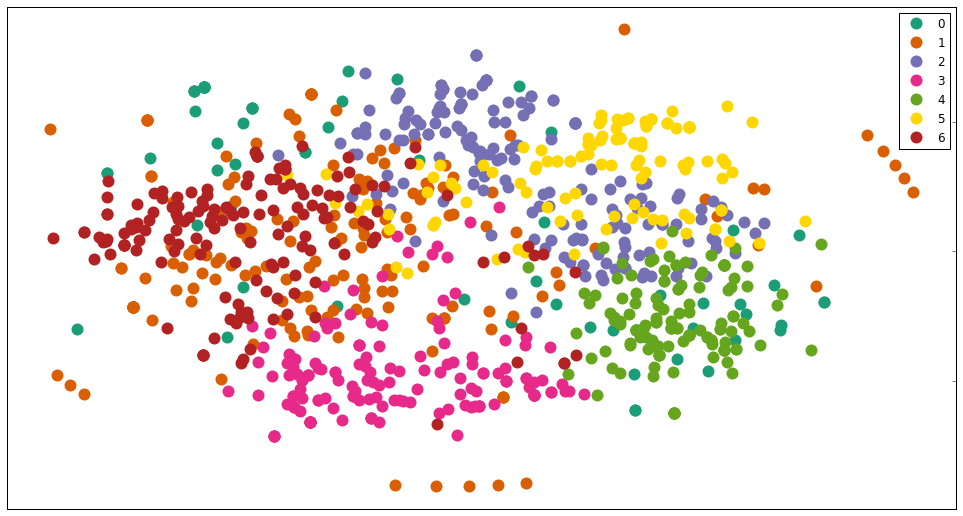

In [36]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point


    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [38]:
# Look for best number of clusters using silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(dist, clusters)
print(silhouette_avg)
print("silhouette 7: 0.2024196885')

0.2024196885


### Compare K Means clustering with human generated scores ###

In [39]:
# Since each response in this list also has a score from 1-5, we can compare the clustering with the assigned score
clusters2 = c['Score'].tolist()
both = { 'sent': text, 'cluster': clusters2}
frame = pd.DataFrame(both, index = [clusters2] , columns = ['cluster'])
c['Score'].value_counts() #number of responses per cluster (clusters from 1 to 5)
# Not very much in 3/5 of these categories

4    212
2    196
3    165
5    131
7     98
6     97
8     79
Name: Score, dtype: int64

In [42]:
new_list = c['Score']

#set up cluster names using a dict
cluster_names2 = {2: '2', # Scores from 1-7
                  3: '3', 
                  4: '4', 
                  5: '5', 
                  6: '6',
                  7: '7',
                  8: '8'}

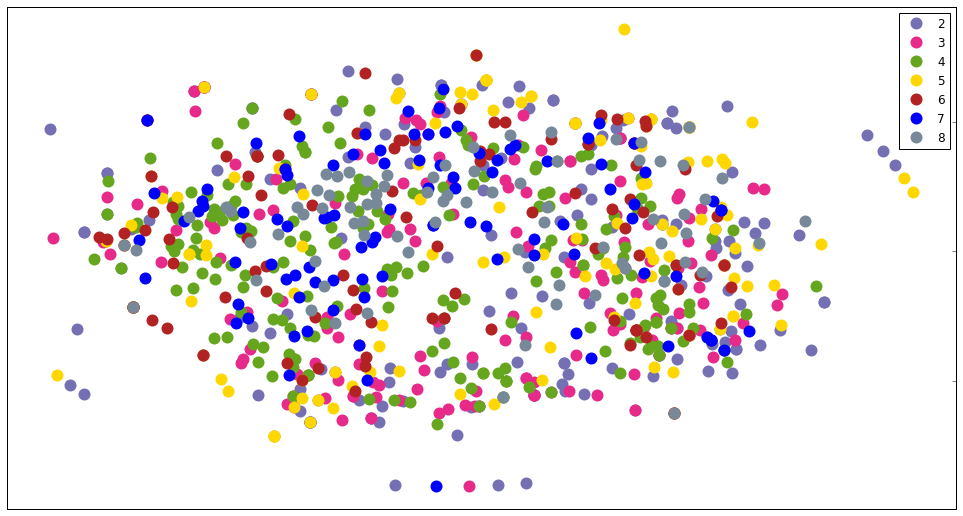

In [43]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters2)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names2[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

    
plt.show() #show the plot

#plt.savefig('clusters_small_noaxes.png', dpi=200)

### How Many Clusters? ###

The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. Higher silhouette scores generally show more distinct differences between clusters. Silhouette scores for the range from 2-9 clusters that I tried were all quite low. While the human scores fall into 5 groups, the silhouette score shows that there might be more differences with 6-8 clusters. After looking at diagrams of the clusters for higher cluster numbers, it seems that these cause a lot of overlap between clusters. 

Overall clustering seems pretty difficult to do on the entire corpus of this data. The key words generated from each cluster are basically the same for every cluster, but with different frequencies. This is probably because even if students are using words incorrectly, they still often use the correct vocabulary. One way to create more interesting clusters might be to break down this data further by something like human-generated score and then find clusters that might show something different.

### Comparing Clusters to Human Generated Scores ###

It seems that some of the groups from human scores were somewhat intact in the k means clustering. The "2" scores heavily outweigh all of the other scores (~80% of the data), so it's not surprising that they seem to spread in and around the other clusters. However, the other groupings fall at least mostly in the same regions.